In [1]:
from tsai.all import *
import logging
import matplotlib.pyplot as plt
import zarr
import sklearn.metrics as skm
import seaborn as sns
# import tensorflow
# from tensorflow.python.client import device_lib

/home/hubert/Documents/PredictiveMaintenanceGearBox/venv/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/hubert/Documents/PredictiveMaintenanceGearBox/venv/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# def get_available_devices():
#     local_device_protos = device_lib.list_local_devices()
#     return [x.name for x in local_device_protos]

# print(get_available_devices())

In [3]:
computer_setup()

os             : Linux-5.4.0-146-generic-x86_64-with-glibc2.29
python         : 3.8.10
tsai           : 0.3.1
fastai         : 2.7.9
fastcore       : 1.5.24
torch          : 1.11.0+cu102
device         : 1 gpu (['NVIDIA GeForce GTX 980 Ti'])
cpu cores      : 12
RAM            : 15.55 GB
GPU memory     : [5.94] GB


In [4]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
%matplotlib inline

In [5]:
def list_from_file(filename):
    with open(filename, "rb") as fp:
        return pickle.load(fp)

In [6]:
#Size of data
valid_size = 0.2
test_size = 0.05
str_size_of_data = 'valid_size_' + str(valid_size) + 'test_size_' + str(test_size)
# time resolution
# example 0.001 s -> 0.002 s 
resolution = 0.01
#dates
file_data = '23_11'
today_date = '17_01'
#Problem to solve
problem = "Multiclass_one_model"

file_for_train_data = 'train_data_' + file_data
file_for_train_data_x = file_for_train_data + '_x'
file_for_train_data_y = file_for_train_data + '_y'

folder_to_save_base = 'models' + '/' + problem + '/' + str_size_of_data + '/'

In [7]:
logger.info(f"Get train data from files: {file_for_train_data_x}, {file_for_train_data_y}")
X = list_from_file(file_for_train_data_x)
Y = list_from_file(file_for_train_data_y)

INFO:__main__:Get train data from files: train_data_23_11_x, train_data_23_11_y


In [8]:
# Define models to train
models = [
    # {
    #     'name': 'LSTM', 
    #     'model': LSTM, 
    #     'params': [
    #         {'hidden_size': 100, 'bidirectional': True},
    #         {'hidden_size': 1000, 'bidirectional': True},
    #     ]
    # },
    # {
    #     'name': 'LSTM_FCN', 
    #     'model': LSTM_FCN, 
    #     'params': [
    #         {'hidden_size': 100, 'bidirectional': True},
    #         {'hidden_size': 1000, 'bidirectional': True},
    #     ]
    # },
    {
        'name': 'FCNPlus', 
        'model': FCNPlus, 
        'params': [
            {'hidden_size': 100},
            {'hidden_size': 1000, 'fc_dropout': .3},
        ]
    },
    {
        'name': 'TST', 
        'model': TST, 
        'params': [
            {'hidden_size': 1000, 'dropout': .3},
            {'hidden_size': 1000, 'dropout': .1, 'fc_dropout': .8},
        ]
    },
]

In [9]:
path = Path('data')
if not os.path.exists(path): os.makedirs(path)

In [10]:
logger.info("Create numpy array with X and Y")
X_largest = np.array(X)
y_large = np.array(Y)

# logger.info("Sample X for every 100 samples")
# to take with resolution defined before:
samples_to_take = resolution * 1000
X_large = X_largest[:, :, :: int(samples_to_take)]
X_large.shape

INFO:__main__:Create numpy array with X and Y


(420, 4, 4001)

In [11]:
X_large_zarr = zarr.open(path/'X_large.zarr', mode='w', shape=X_large.shape, dtype=X_large.dtype, chunks=(1, -1, -1))
# chunks=(1, -1, -1) == (1, None, None)
X_large_zarr[:] = X_large

In [12]:
X_large_zarr = zarr.open(path/'X_large.zarr', mode='r')
y_large_zarr = zarr.open(path/'y_large.zarr', mode='w', shape=y_large.shape, dtype=y_large.dtype, chunks=False) # y data is small and don't need to be chunked
y_large_zarr[:] = y_large

INFO:__main__:Split data to train and valid


stratify set to False as the least populated class in o has only 1 member, which is too few.


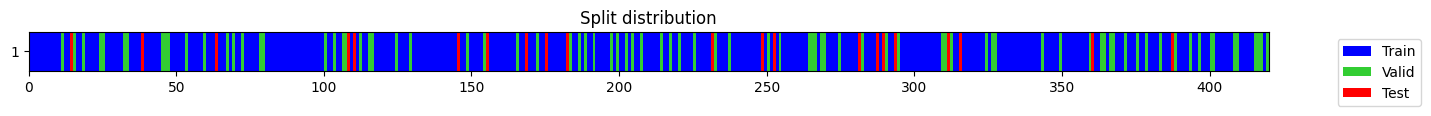

((#315) [355,357,240,216,334,3,22,96,117,407...],
 (#84) [67,266,416,154,25,112,217,419,199,186...],
 (#21) [175,145,63,387,231,293,287,289,315,248...])

In [13]:
train_only              = False  # set to True for debugging (valid = train)
stratify                = True
balance                 = False
shuffle                 = True
predefined_splits       = None
show_plot               = True 


check_splits = True
random_state = 23
logger.info("Split data to train and valid")
#Set show plot to True if you want to see split, but this stops main thread
splits = get_splits(X_large_zarr, valid_size=valid_size, test_size=test_size, shuffle=shuffle, balance=balance, stratify=stratify,
                    train_only=train_only, check_splits=check_splits, random_state=random_state, show_plot=show_plot, verbose=True)
splits

In [14]:
tfms  = [None, TSClassification()] # TSClassification == Categorize
batch_tfms = TSStandardize(by_var=True)
dls = get_ts_dls(X_large_zarr, y_large_zarr, splits=splits, tfms=tfms, batch_tfms=batch_tfms, inplace=False, bs=8, num_workers=12) 
# num_workers = 1 *cpus
dls.show_batch(sharey=True)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

: 

In [ ]:
#Take test data
X_test , y_test = np.take(X_large_zarr, splits[2], axis=0), np.take(y_large_zarr, splits[2], axis=0)

In [ ]:
valid_dl = dls.valid
test_ds = valid_dl.dataset.add_test(X_test, y_test)
test_dl = valid_dl.new(test_ds)

next(iter(test_dl))

(TSTensor(samples:8, vars:4, len:4001, device=cpu, dtype=torch.float32),
 TensorCategory([6, 4, 5, 4, 6, 7, 3, 4]))

In [ ]:
def fit_cycle(stage, learner):
    logger.info(f"Fit {stage} cycle")
    learner.fit_one_cycle(300, lr_max=1e-3)
    learner.save('stage'+ str(stage))
    learner.recorder.plot_metrics()

INFO:__main__:Training LSTM_FCN...
INFO:__main__:With parameters: {'hidden_size': 100, 'bidirectional': True}
INFO:__main__:Save learner as stage0
INFO:__main__:Folder to save: models/Multiclass_one_model/valid_size_0.2test_size_0.05//LSTM_FCN/100/True


INFO:__main__:Fit 1 cycle


epoch,train_loss,valid_loss,accuracy,time
0,2.135750,11.712614,0.273810,00:19
1,2.051922,14.891035,0.214286,00:19
2,1.981030,15.833659,0.214286,00:19
3,1.935107,14.140514,0.273810,00:19
4,1.888833,15.979909,0.107143,00:19
5,1.852718,14.584642,0.261905,00:19
6,1.823737,14.506236,0.107143,00:19
7,1.772725,16.308144,0.107143,00:19
8,1.735389,20.553997,0.107143,00:19
9,1.705934,32.915794,0.107143,00:19


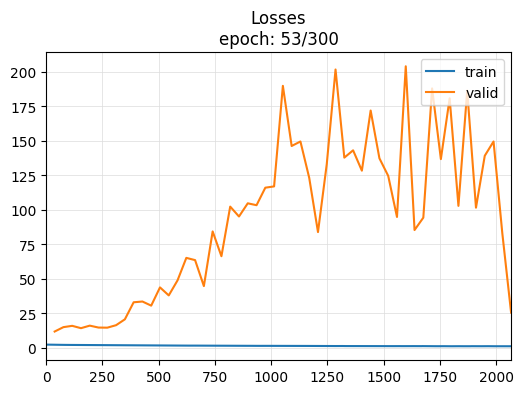

In [ ]:
# Train and evaluate models in a loop
for model_dict in models:
    model_name = model_dict['name']
    model_class = model_dict['model']
    model_params = model_dict['params']

    logger.info(f'Training {model_name}...')
    for params in model_params:
        folder_to_save = folder_to_save_base + '/' + model_name
        logger.info(f'With parameters: {params}')
        #TODO: PROVIDED HERE MODEL HAS LESS ARGUMENTS THAN REQUIRES GO TO MODEL_MULTIPLE
        if model_class == TST:
            model = model_class(dls.vars, dls.c, dls.len, **params)
        elif model_class == LSTM_FCN:
            model = model_class(dls.vars, dls.c, seq_len=X_large_zarr.shape[-1], **params)
        else:
            model = model_class(dls.vars, dls.c, **params)
        learn = Learner(dls, model=model, metrics=accuracy, cbs=ShowGraph())
        logger.info("Save learner as stage0")
        params_string = '/'.join(f'{v}' for k, v in params.items())
        folder_to_save += '/' + params_string
        logger.info(f'Folder to save: {folder_to_save}')
        learn.save('stage0')
        learn.lr_find()
        try:
            for stage in range(1,4):
                fit_cycle(stage, learn)
                interp = ClassificationInterpretation.from_learner(learn)
                interp.plot_confusion_matrix()
                plt.show()
                learn.save_all(path=folder_to_save, dls_fname='dls', model_fname='model', learner_fname='learner')
                logger.info("Get test preds:")
                test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
                logger.info(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')
                logger.info(f'recall: {skm.recall_score(test_targets, test_preds, average="macro"):10.6f}')
                logger.info(f'precision: {skm.precision_score(test_targets, test_preds, average="macro"):10.6f}')
                logger.info(f'jaccard: {skm.jaccard_score(test_targets, test_preds, average="macro"):10.6f}')
                conf_mat = skm.confusion_matrix(test_targets, test_preds)
                sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
                plt.show()
        except:
            print("Except accured, cannot fit this model")
            pass
        

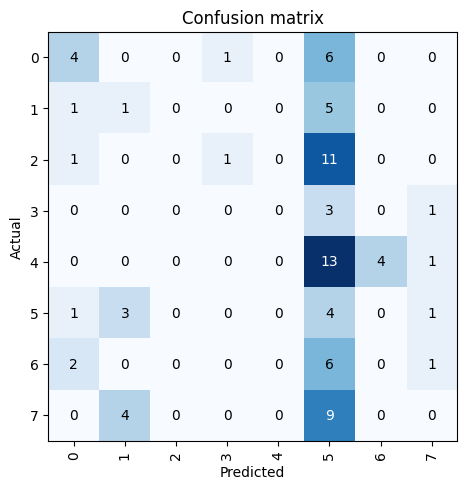

In [ ]:
#sF - Dryft czujnika
#sV - Shaft Wear, Zużycie wału
#sT - Tooth fault, Uszkodzenie zęba przekładni

#faultCode = sF + 2*sV + 4*sT
# 0 - brak uszkodzeń
# 1 - Dryft czujnika
# 2 - Zużycie wału
# 3 - Dryft czujnika + Zużycie wału
# 4 - Uszkodzenie zęba przekładni
# 5 - Uszkodzenie zęba przekładni + Dryft czujnika
# 6 - Uszkodzenie zęba przekładni + Zużycie wału
# 7 - Uszkodzenie zęba przekładni + Zużycie wału + Dryft czujnika

(array([56., 42., 56., 42., 64., 48., 64., 48.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <BarContainer object of 8 artists>)

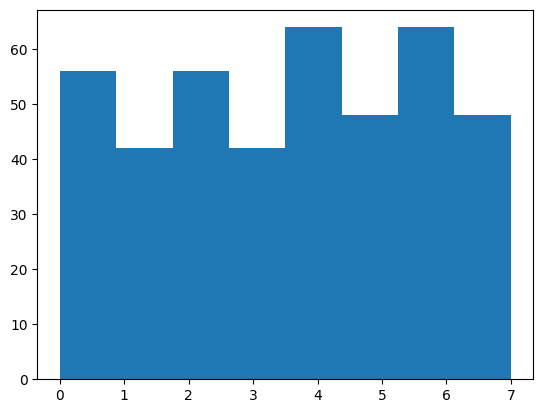

In [ ]:
plt.hist(Y, 8)